# In this notebook, a unit square mesh is used to show some basic commands which we will be using in fenics implementation.  

* Different methods to import the mesh
* Print the cordinates, vertex, cells
* Save dof in xdmf file 
* Visualise the cell data and point data in Paraview

## 1. Import dolfin module

In [17]:
from dolfin import *
import numpy as np

## 2. Mesh

## Next two ways of using the mesh is shown
1. Importing mesh saved as xdmf file
2. Using the inbuilt mesh in dolfin

### Inbuilt mesh

In FEniCS we have following built-in meshes -
1. UnitIntervalMesh
2. UnitSquareMesh
3. RectangleMesh
4. UnitCubeMesh
5. BoxMesh

- Unit Interval Mesh - `mesh = UnitIntervalMesh(N)`  
N defines the number of parts in which it is divided.

- Unit Square Mesh - `mesh = UnitSquareMesh(Nx,Ny,"Orientation")`  
Nx defines the number of parts in which X-axis is divided.  
Ny defines the number of parts in which Y-axis is divided.  
"Orientation"defines the orientation of the diagonal it can be *left*, *right*, *left/right* and *crossed* . It is optional.

- RectangleMesh - `mesh = RectangleMesh(Point(x0, y0), Point(x1, y1), Nx, Ny, "Orientation")`  
x0,y0,x1 and y1 represents the coordinates of the two extreme points in the principal diagonal of the rectangle.
Nx, Ny and "Orinetation" holds the same meaning as above.

- Unit Cube Mesh - `UnitCubeMesh(Nx, Ny, Nz)`  
Nx,Ny and Nz holds the same meaning as above stated.  

- Box Mesh - `mesh = BoxMesh(Point(x0, y0, z0), Point(x1, y1, z1), Nx, Ny, Nz)`  
x0,y0,z0,x1,x2 and x3 defines the coordinates of the two extreme points of the principal diagonal of the box/cuboid.  
Nx,Ny and Nz holds the same meaning as above stated.

[Reference](https://fenicsproject.org/olddocs/dolfin/2019.1.0/python/demos/built-in-meshes/demo_built-in-meshes.py.html) for reading.




Plotting a UnitIntervalMesh


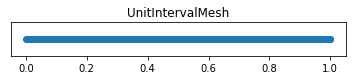

In [22]:
mesh = UnitIntervalMesh(500)
print( "Plotting a UnitIntervalMesh")
plot(mesh, title="UnitIntervalMesh")

**The difference in "right/left" and "crossed" is that in the former one the meshes are prdocues alternatively right and left, whereas in the later one, both the diagonals are present in the each cell.**

### Create the vector function space in mesh 

To define the properties of mesh including the shape function(or element family) and degree of freedom, we use `VectorFunctionSpace`. Vector function space represents that the dof per nod is 2  
`V = VectorFunctionSpace(mesh, 'Element family', degree=x)`  
here `Element Family` - `'CG'`, `'DG'`, `'R'`, `'Q'` etc. which denotes Lagrange, Discontinuous Lagrange, Real, Quadrature respectively.  
`x` is the degree of element which can be 0, 1, 2 etc.  

One can also [refer](https://computationalmechanics.in/data-structure-of-fem-in-fenics/) this to know more about this

### DOF to vertex map

This helps to plot the dof of all corresponding vertices.`vertex_to_dof_map(V)` is the function which will give dof in vector form. We are using the `reshape` function so as to modify the output, it will produce a matrix of order $m*n$ `v2d = v2d.reshape(m, n)`  
Here, `-1` is standard input if the number of matrix row is unknown.  
`mesh.geometry().dim()`is the dimension of mesh geometry, here it is $2$ 

### Save the dof in a xdmf file which can be visualised in Paraview
Sometimes for complex shape with very large number of elements, it becomes extremely difficult to understand the dof for various vertex, therefore in such cases the file is exported in .xdmf format which can be visulized in Paraview.
The written command generates the `dof.xdmf` file.
* Press V to visualise the cell and point data correspondng to a specific dof. (in Paraview)

Additionally one can also check number of vertices,cells and edges etc., mesh cell vertices, dof coordinates with the following commands- 
`print(dof_map.vector()[:])` - prints dof of the mesh in vector form (in general, we prefer the array form)  
`print(mesh.cells())` - prints the list of vertices for differents cells  
`V.tabulate_dof_coordinates()` - prints the dof of the the coordinates.  
`mesh.coordinates()` - prints the coordinates of the vertices.  
`mesh.num_cells()` - prints the number of cells in the mesh  
`mesh.num_edges()` - prints the number of edges in the mesh  
`mesh.num_vertices()` - prints the number of vertices in the mesh  

If one wishes to plot vertices corresponding to different edges, triangle (for 2D) , tetrahedrons (for 3D), then following commands can be used.

# In this tutorial, we show how to solve the Poisson equation in 1D

$-\frac{\partial^{2} u}{\partial^{2} x}=f(x) \quad \forall x \in(0,1)$

with homegeneuos Dirichlet boundary conditions u(0)=u(1)=0.

Below we solve the problem using FEniCS for the choice $ f(x)=sin(πx)$

## 3. FunctionSpace

FunctionSpace is a dolfin class that constructs the finite element space. It takes as inputs the mesh, the type of finite element (CG stands for Continuous Galerkin elements), and the finite element order (in our case 1, since we are using linear finite element).

In [23]:
V = FunctionSpace(mesh, 'CG', 1)
print ("Number of dofs", V.dim())

Number of dofs 501


We define the right hand side of the PDE using the dolfin class Expression. This class takes as input a string that define the analytical form of the expression and the polynomial degree degree of the expression (if the expression is not a polynomial it will be interpolated). Here x[0] denotes the x coordinate of the mesh. In 2D, x[1] denotes the y coordinate of the mesh. Additional parameters can be passed to the expression. In this case we define the frequency ω=π as a parameter for the expression.

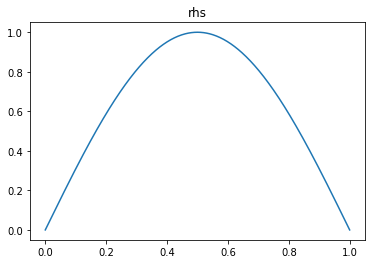

In [24]:
# Define the right hand side. "x[0]" denotes the space coordinate x.
f = Expression("sin(omega*x[0])", omega = pi, degree = 5)

#visualize the rhs:
plot(f,mesh=mesh, title="rhs")

We define the Dirichlet boundary condition on the u(0)=u(1)=0. The class Constant is similar Expression and it is used when we need to represent a value that is constant in space. 
As input it takes the value of the constant. 
DirichletBC is the dolfin class that is used to describe Dirichlet boundary conditions. 
It takes three inputs: the finite element space V, the expression/value of the Dirichlet boundary condition u_bc, and finally a function that returns true if the point x belongs to a portion of the Dirichlet boundary.

In [26]:
u_bc = Constant(0.)
def dirichlet_boundary(x,on_boundary):
    return on_boundary
bcs = [DirichletBC(V, u_bc, dirichlet_boundary)]

## 4. Define the weak form

We now write the weak form of the Poisson equation:

* uh, the trial function, is an instance of the dolfin class TrialFunction
* vh, the test function, is an instance of the dolfin class TestFunction
* grad is the gradient operator acting on either a trial or test function. (In 1D grad:=ddx).
* inner is the product of two scalar, vector, or tensor functions
* dx denotes that the integration is performed on the whole domain. 
* ds (see next example) denotes that the integration is on the boundary of the domain.

In [27]:
# Define the trial function u and the test function v
uh = TrialFunction(V)
vh = TestFunction(V)

# Define the weak form for the stiffness matrix (A_form) and for the rhs (b_form):
A_form = inner(grad(uh), grad(vh))*dx
b_form = inner(f,vh)*dx

## 5. Assemble and solve the finite element discrete problem

We now assemble the finite element stiffness matrix A and the right hand side vector b using the dolfin method assemble_system. assemble_system takes the following inputs: the bilinear form A_form, the linear form b_form, and a list of Dirichlet boundary conditions bcs. This method will automatically generate and compile efficient c++ code to perform the local assembly on each element of the mesh, and it returns the assembled global matrices after applying the Dirichlet boundary conditions.

We now define the finite element function uh = Function(Vh) that represents the solution of the PDE. The interpolation weights are stored in uh.vector(). We use the solve(A,u,b) command to solve the linear system Au=b.

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


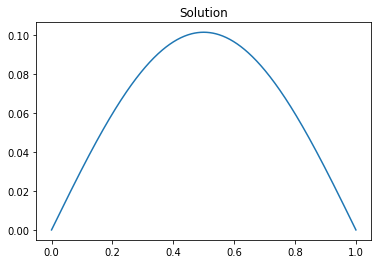

In [29]:
# Assemble the stiffness matrix A and rhs b. Apply the boundary conditions
A, b = assemble_system(A_form, b_form, bcs)

# Solve the linear system and visualize the solution
uh = Function(V)
solve(A, uh.vector(), b)
#plt.figure()
plot(uh, title = "Solution")

Reference:
1D bar poisson problem : https://uvilla.github.io/inverse17/02_IntroToFenics/Poisson1D.html